<a href="https://colab.research.google.com/github/JaniVarga/Skin_detection/blob/main/Sematic_Segmentation_FCN_ResNet50_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image semantic segmentation using FCN-ResNet50 with PyTorch

link: https://github.com/sovit-123/CamVid-Image-Segmentation-using-FCN-ResNet50-with-PyTorch

In [1]:
import torch

device="cuda" if torch.cuda.is_available() else "cpu"
if device=="cuda":
    print("GPU is available")
    !nvidia-smi -L
else:
    print("GPU is not available, using CPU")

GPU is available
GPU 0: Tesla T4 (UUID: GPU-a179a77e-9df5-b1db-b918-c3136f8ab363)


In [2]:
# import shutil
# shutil.rmtree('/content/dataset')

# !rm -rf "/content/dataset"

In [3]:
from zipfile import ZipFile

try:
  with ZipFile("/content/dataset.zip", "r") as zip_ref:
      zip_ref.extractall("/content")

except FileNotFoundError:
  print("dataset.zip file not found.")

else:
  print("dataset.zip file extracted successfully.")

# finally:
  # finally block will be executed regardless if the try block raises an error or not.

dataset.zip file extracted successfully.


link: https://realpython.com/python-lbyl-vs-eafp/

Use LBYL for:
  * Operations that are likely to fail
  * Irrevocable operations, and operations that may have a side effect
  * Common exceptional conditions that can be quickly prevented beforehand

Use EAFP for:

  * Operations that are unlikely to fail
  * Input and output (IO) operations, mainly hard drive and network operations
  * Database operations that can be rolled back quickly

In [4]:
import os

try:
  os.remove("/content/dataset.zip")

except FileNotFoundError:
  print("dataset.zip file not found.")

else:
  print("dataset.zip file removed successfully.")

# or
# !rm "/content/dataset.zip"

# Read the link above!
# if not os.path.exists("/content/dataset.zip"):
#   print("dataset.zip file not found.")
# else:
#   os.remove("/content/dataset.zip")
#   print("dataset.zip file removed.")

dataset.zip file removed successfully.


In [5]:
from pathlib import Path

root_dir_path = Path("/content/dataset")
train_dataset_path = root_dir_path / "train"
val_dataset_path = root_dir_path / "val"

train_dataset_path, val_dataset_path

(PosixPath('/content/dataset/train'), PosixPath('/content/dataset/val'))

In [6]:
images_dataset = root_dir_path.glob("**/images/*.jpeg")
masks_dataset = root_dir_path.glob("**/masks/*.png")

In [7]:
list_of_images = sorted(list(images_dataset))
list_of_masks = sorted(list(masks_dataset))

In [8]:
from torchvision.io import read_image

# img = read_image(list_of_images[0])
# mask = read_image(list_of_masks[0]).permute(1, 2, 0)

In [9]:
from PIL import Image

img = Image.open(list_of_images[0])
mask = Image.open(list_of_masks[0])

In [10]:
mask.mode, mask.size, mask.getbands()

('1', (352, 288), ('1',))

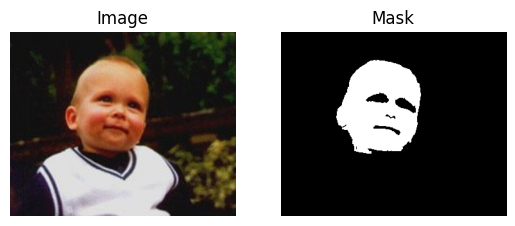

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img)
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")
plt.show()


In [12]:
import torchvision

weights =  torchvision.models.segmentation.FCN_ResNet50_Weights.DEFAULT # "DEFAULT" = Best available weights
weights

FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1

In [13]:
auto_transforms = weights.transforms()
auto_transforms

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [14]:
auto_transforms.describe()

'Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. The images are resized to ``resize_size=[520]`` using ``interpolation=InterpolationMode.BILINEAR``. Finally the values are first rescaled to ``[0.0, 1.0]`` and then normalized using ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.'

In [15]:
from torchvision.transforms import v2

auto_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Resize(size=(520,520)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
auto_transforms

Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[520, 520], interpolation=InterpolationMode.BILINEAR, antialias=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [17]:
# link: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
from torchvision.transforms.functional import pil_to_tensor
from torch.utils.data import Dataset
import glob
import numpy as np

class CustomImageDataset(Dataset):
  def __init__(self, data_root_path , transform=None):
    self.images_dataset = sorted(glob.glob(pathname=f"{data_root_path}/images/*.*"))
    self.masks_dataset = sorted(glob.glob(pathname=f"{data_root_path}/masks/*.*"))
    self.transform = transform

  def __len__(self):
    return len(self.images_dataset)

  def __getitem__(self, index):
    image = Image.open(self.images_dataset[index])
    mask = Image.open(self.masks_dataset[index])
    mask = v2.Resize(size=(520, 520))(pil_to_tensor(mask).to(torch.float32))


    if self.transform:
      return self.transform(image), mask
    else:
      return torch.tensor(image), torch.tensor(mask)

In [18]:
img, mask = CustomImageDataset(data_root_path=train_dataset_path, transform=auto_transforms).__getitem__(0)

In [19]:
img.shape,img.dtype, mask.shape, mask.dtype

(torch.Size([3, 520, 520]),
 torch.float32,
 torch.Size([1, 520, 520]),
 torch.float32)

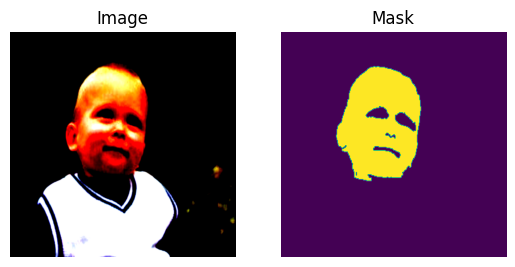

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img.permute(1, 2, 0))
ax[0].set_title("Image")
ax[0].axis("off")
ax[1].imshow(mask.permute(1, 2, 0))
ax[1].set_title("Mask")
ax[1].axis("off")
plt.show()

In [21]:
train_dataset_path = root_dir_path / "train"
val_dataset_path = root_dir_path / "val"

In [22]:
# Create `DataLoaders` using automatic transforms
train_dataset = CustomImageDataset(data_root_path=train_dataset_path,
                                   transform=auto_transforms)

test_dataset = CustomImageDataset(data_root_path=val_dataset_path,
                                  transform=auto_transforms)

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=8,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=8,
                              shuffle=False,
                              num_workers=2,
                              pin_memory=True
                             )

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ed287e1aad0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ed287e1b700>)

In [24]:
def dice_coefficient(prediction, target, epsilon=1e-07):
    prediction_copy = prediction.clone()

    prediction_copy[prediction_copy < 0] = 0
    prediction_copy[prediction_copy > 0] = 1

    intersection = abs(torch.sum(prediction_copy * target))
    union = abs(torch.sum(prediction_copy) + torch.sum(target))
    dice = (2. * intersection + epsilon) / (union + epsilon)

    return dice

In [25]:
!pip install torchinfo

In [26]:
model = torchvision.models.segmentation.fcn_resnet50()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 127MB/s]


In [27]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 520, 520),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
FCN (FCN)                                     [1, 3, 520, 520]     [1, 21, 520, 520]    --                   True
├─IntermediateLayerGetter (backbone)          [1, 3, 520, 520]     [1, 2048, 65, 65]    --                   True
│    └─Conv2d (conv1)                         [1, 3, 520, 520]     [1, 64, 260, 260]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 260, 260]    [1, 64, 260, 260]    128                  True
│    └─ReLU (relu)                            [1, 64, 260, 260]    [1, 64, 260, 260]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 260, 260]    [1, 64, 130, 130]    --                   --
│    └─Sequential (layer1)                    [1, 64, 130, 130]    [1, 256, 130, 130]   --                   True
│    │    └─Bottleneck (0)                    [1, 64, 130, 130]    [1, 256, 130, 130]  

In [28]:
model.classifier

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)

In [29]:
from torch import nn

model.classifier = nn.Sequential(
    nn.Conv2d(in_channels=2048, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(),
    nn.Dropout(p=0.1, inplace=False),
    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
).to(device)

model.classifier

Sequential(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [30]:
summary(model=model,
        input_size=(1, 3, 520, 520),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
FCN (FCN)                                     [1, 3, 520, 520]     [1, 1, 520, 520]     --                   True
├─IntermediateLayerGetter (backbone)          [1, 3, 520, 520]     [1, 2048, 65, 65]    --                   True
│    └─Conv2d (conv1)                         [1, 3, 520, 520]     [1, 64, 260, 260]    9,408                True
│    └─BatchNorm2d (bn1)                      [1, 64, 260, 260]    [1, 64, 260, 260]    128                  True
│    └─ReLU (relu)                            [1, 64, 260, 260]    [1, 64, 260, 260]    --                   --
│    └─MaxPool2d (maxpool)                    [1, 64, 260, 260]    [1, 64, 130, 130]    --                   --
│    └─Sequential (layer1)                    [1, 64, 130, 130]    [1, 256, 130, 130]   --                   True
│    │    └─Bottleneck (0)                    [1, 64, 130, 130]    [1, 256, 130, 130]  

In [31]:
torch.cuda.empty_cache()

In [32]:
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

In [33]:
# https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

# The model returns an OrderedDict with two Tensors that are of the same height and width as the input Tensor,
# but with 21 classes. output['out'] contains the semantic masks,
# and output['aux'] contains the auxiliary loss values per-pixel.
# In inference mode, output['aux'] is not useful. So, output['out'] is of shape (N, 21, H, W)

from tqdm import tqdm

EPOCHS = 5

train_losses = []
train_dcs = []
val_losses = []
val_dcs = []

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)

        y_pred = model(img)["out"]
        optimizer.zero_grad()
        # print(f"\n\n\nY_pred shape: {y_pred.shape}")
        # print(f"Mask shape: {mask.shape}\n\n\n")
        # y_pred_tensor = y_pred['out']

        # dc = dice_coefficient(y_pred, mask)
        loss = loss_fn(y_pred, mask)

        train_running_loss += loss.item()
        # train_running_dc += dc.item()

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    # train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    # train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    # val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(test_dataloader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)

            y_pred = model(img)["out"]
            loss = loss_fn(y_pred, mask)
            # dc = dice_coefficient(y_pred, mask)

            val_running_loss += loss.item()
            # val_running_dc += dc.item()

        val_loss = val_running_loss / (idx + 1)
        # val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    # val_dcs.append(val_dc)

    print("-" * 30)
    print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
    # print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
    print("\n")
    print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
    # print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
    print("-" * 30)

# Saving the model
torch.save(model.state_dict(), 'my_checkpoint.pth')

 20%|██        | 1/5 [13:07<52:29, 787.26s/it]

------------------------------
Training Loss EPOCH 1: 0.1560


Validation Loss EPOCH 1: 0.1387
------------------------------


 40%|████      | 2/5 [26:24<39:39, 793.11s/it]

------------------------------
Training Loss EPOCH 2: 0.1074


Validation Loss EPOCH 2: 0.1016
------------------------------


 60%|██████    | 3/5 [39:40<26:29, 794.66s/it]

------------------------------
Training Loss EPOCH 3: 0.0929


Validation Loss EPOCH 3: 0.1252
------------------------------


 80%|████████  | 4/5 [52:56<13:15, 795.17s/it]

------------------------------
Training Loss EPOCH 4: 0.0874


Validation Loss EPOCH 4: 0.0995
------------------------------


100%|██████████| 5/5 [1:06:12<00:00, 794.49s/it]


------------------------------
Training Loss EPOCH 5: 0.0829


Validation Loss EPOCH 5: 0.0947
------------------------------


In [35]:
test_img_path = "/content/1728293261557.jpeg"
test_img = Image.open(test_img_path)
test_img = auto_transforms(test_img).unsqueeze(0).to(device)

model.eval()
with torch.inference_mode():
    y_logits = model(test_img)["out"]
    y_pred = torch.round(torch.sigmoid(y_logits))

In [36]:
pred_mask =y_pred.to("cpu").squeeze()

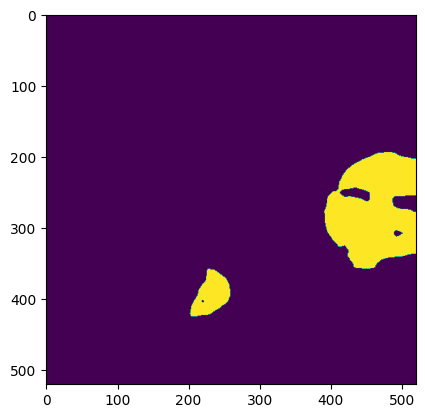

In [37]:
plt.imshow(pred_mask)